In [2]:
import numpy as np
import matplotlib.pyplot as plt

Heatequation

$\partial_t T(x,t) = \alpha \frac{d^2 T}{dx^2}(x,t)$ 

$T_0 (0) = 273$

$T(t,0) = 273$

$T(t,1) = 400$

In [37]:
class Solution:
    def __init__(self, T0, Tleft, Tright, Ntime, Nspace) -> None:
        self.solution = np.zeros((Ntime, Nspace))
        self.Ntime = Ntime
        self.Nspace = Nspace
        self.Tleft = Tleft
        self.Tright = Tright
        self.solution[0,:] = T0
        self.timestep = 0
        self.applyRB()


    def newTime(self):
        self.timestep = self.timestep + 1
        try:
            self.solution[self.timestep, :] = self.solution[self.timestep-1, :]
        except IndexError:
            print("maximum timestep reached")
        self.applyRB()

    def applyRB(self):
        self.solution[self.timestep, 0] = self.Tleft
        self.solution[self.timestep, -1] = self.Tright

    def getVal(self, spaceiter):
        if spaceiter < 0:
            spaceiter = 0
        elif spaceiter > self.Nspace-1:
            spaceiter = self.Nspace-1
        return self.solution[self.timestep, spaceiter]

    def getPreVal(self, spaceiter):
        if spaceiter < 0:
            spaceiter = 0
        elif spaceiter > self.Nspace-1:
            spaceiter = self.Nspace-1
        return self.solution[self.timestep-1, spaceiter]

    def setVal(self, spaceiter, value):
        if spaceiter <= 0:
            pass
        elif spaceiter >= self.Nspace-1:
            pass
        else:
            self.solution[self.timestep, spaceiter] = value

    def getTimestep(self):
        return self.solution[self.timestep, :]

    def getPreTimestep(self):
        return self.solution[self.timestep-1, :]

In [38]:
# numerical Definitions:
Ntime = 200
Nspace = 200
dx = 0.1
dt = 1e-1


# physical parametrization
T1 = 273
T2 = 400
alpha = 0.1
sol = Solution(T1, T1, T2, Ntime, Nspace)

# newton settings 
damping = 0.5
max_iter = 100
tol = 1e-10

# Discretization Scheme:

$\frac{T^{n+1}_i-T^n_i}{\Delta t} = \alpha \frac{T^{n+1}_{i-1}-2T^{n+1}_i + T^{n+1}_{i+1}}{\Delta x^2}$

define F such
 
$F(T) = 0$

In [39]:
def F(solution, spaceiter, dT=0):
    Tnewleft = solution.getVal(spaceiter-1) + dT
    Tnewright = solution.getVal(spaceiter+1) + dT
    Tnewmiddle = solution.getVal(spaceiter) + dT
    Toldmiddle = solution.getPreVal(spaceiter) 
    return alpha*dt * (Tnewleft-2*Tnewmiddle+Tnewright)/(dx**2) - Tnewmiddle+Toldmiddle

In [40]:
def JF(solution, spaceiter):
    dT = 1e-6
    return (F(solution, spaceiter, dT) - F(solution, spaceiter, dT=0) ) / dT

In [8]:
def dFdt(solution, spaceiter):
    pass

In [ ]:
def is_within_neighborhood(solution, spaceiter):
    restol = np.sqrt(tol)
    if np.abs(F(solution,spaceiter)) < restol:
        return True
    else:
        return False

In [9]:
def compute_tangent(solution,spaceiter):
    C = np.sqrt(1e-16)
    C = np.max([C,np.abs(1/dFdt(solution, spaceiter))])
    delta_T = -C/JF(solution,spaceiter) * dFdt(solution, spaceiter)
    delta_t = C
    delta = np.array([delta_T, delta_t])
    delta = delta/np.norm(delta)
    return delta

In [ ]:
def tangent_step_length(solution, spaceiter, delta, deltat):
    tempsol = solution.getTimestep().deepcopy()
    maxiter = 5
    tmin = 1e-3 # CFL 1
    tmax = dt # CFL 10 
    alpha_min = tmin / delta[1]
    alpha_max = tmax / delta[1]
    Delta = (alpha_max-alpha_min)/maxiter
    converged = False
    alpha = alpha_max
    while ((alpha > alpha_min-Delta) and (converged is False)):
        Tnew = tempsol + alpha * compute_tangent(solution, spaceiter)
        deltatprime = deltat + alpha * delta[1]
        if is_within_neighborhood(solution,spaceiter) is True:
            converged = True
        alpha = alpha - Delta
    return alpha



In [41]:
for i in range(0, Ntime-1):
    iter = 0
    error = 9e9
    print(f"Time t = {i*dt}")
    sol.newTime()

    while ((error > tol) and (iter <= max_iter)):
        iter = iter + 1
        dx_pre = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
        for j in range(0, Nspace):
            J = JF(sol, j)
            f = F(sol, j)
            sol.setVal(j, sol.getVal(j) - damping * f/J)
        dx_post = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
        error = np.abs(dx_post-dx_pre)
        print(f"Iteration {iter}: error: {error} tol: {tol}")


Time t = 0.0
Iteration 1: error: 63.50000016032209 tol: 1e-10
Iteration 2: error: 15.874999959919478 tol: 1e-10
Iteration 3: error: 1.0020130503107794e-07 tol: 1e-10
Iteration 4: error: 0.9921875325654241 tol: 1e-10
Iteration 5: error: 1.690896738182346e-07 tol: 1e-10
Iteration 6: error: 2.108398408379003 tol: 1e-10
Iteration 7: error: 3.647949142759899e-08 tol: 1e-10
Iteration 8: error: 0.5154724421404353 tol: 1e-10
Iteration 9: error: 0.496093771023709 tol: 1e-10
Iteration 10: error: 0.3686790610826165 tol: 1e-10
Iteration 11: error: 0.24804687474232878 tol: 1e-10
Iteration 12: error: 0.07039905216828402 tol: 1e-10
Iteration 13: error: 0.07751465349440423 tol: 1e-10
Iteration 14: error: 0.06576255365672523 tol: 1e-10
Iteration 15: error: 0.05038452457921494 tol: 1e-10
Iteration 16: error: 0.036360364372967524 tol: 1e-10
Iteration 17: error: 0.02519226238706551 tol: 1e-10
Iteration 18: error: 0.014680107487663463 tol: 1e-10
Iteration 19: error: 0.010764242141988234 tol: 1e-10
Iteratio

Text(0, 0.5, 'T / K')

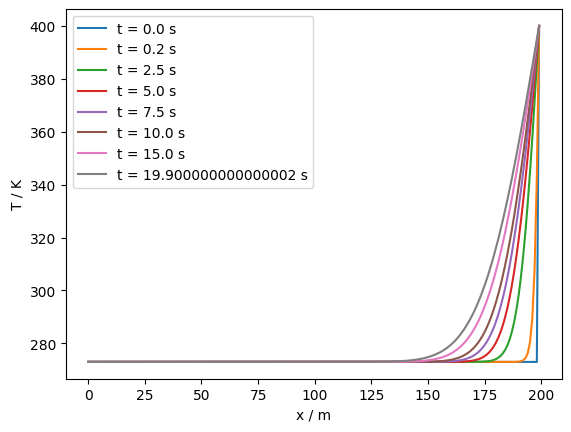

In [42]:
timesteps = [0,2,25,50,75,100, 150, 199]
for it in timesteps:
    plt.plot(sol.solution[it,:], label=f"t = {dt*it} s")
plt.legend()
plt.xlabel("x / m")
plt.ylabel("T / K")